In [1]:
import tensorflow as tf
import pandas as pd

In [2]:
print(tf.__version__)

2.0.0-alpha0


In [3]:
# Reading Data from tsv
title_basics_df = pd.read_csv('title.basics.tsv', sep='\t')
title_cast_df = pd.read_csv('title.principals.tsv', sep='\t')
title_ratings_df = pd.read_csv('title.ratings.tsv', sep='\t')

name_basics_df = pd.read_csv('name.basics.tsv', sep='\t')
title_akas_df = pd.read_csv('title.akas.tsv', sep='\t')
title_crew_df = pd.read_csv('title.crew.tsv', sep='\t')

In [5]:
title_basics_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [6]:
title_cast_df.tail()

,tconst,ordering,nconst,category,job,characters
32887181,tt9916896,5,nm8181480,writer,\N,\N
32887182,tt9916896,6,nm8119743,writer,\N,\N
32887183,tt9916896,7,nm3114985,producer,producer,\N
32887184,tt9916896,8,nm6812444,composer,\N,\N
32887185,tt9916896,9,nm3249786,composer,\N,\N


In [7]:
title_ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.8,1479
1,tt0000002,6.4,176
2,tt0000003,6.6,1110
3,tt0000004,6.4,107
4,tt0000005,6.2,1815


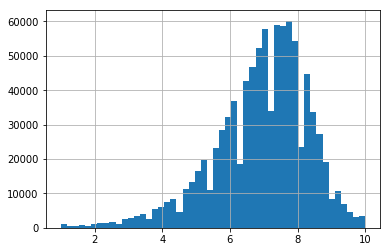

In [8]:
%matplotlib inline
title_ratings_df.averageRating.hist(bins = 50)

In [9]:
name_basics_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0043044,tt0050419,tt0053137,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0037382,tt0038355,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,producer","tt0054452,tt0057345,tt0049189,tt0059956"
3,nm0000004,John Belushi,1949,1982,"actor,writer,soundtrack","tt0080455,tt0078723,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0069467,tt0083922"


In [10]:
title_akas_df.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
1,tt0000001,2,Καρμενσίτα,GR,\N,\N,\N,0
2,tt0000001,3,Карменсита,RU,\N,\N,\N,0
3,tt0000001,4,Carmencita,US,\N,\N,\N,0
4,tt0000001,5,Carmencita,\N,\N,original,\N,1


In [11]:
title_crew_df.head()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N


## Cleaning Data
The year column is converted to integer type and for genre only the first genre is retained as the movie genre.

In [6]:
## Helper Functions to clean data 
## Source: https://www.chrisgiler.com/journal



def clean_year(y):
    # Return year as an integer or 'NaN' if empty
    import numpy as np
    try:
        return int(y)
    except:
        return np.nan

def clean_genre(y):
    # Return only the first genre listed
    y = str(y)
    if y == '\\N':
        return ''
    return y.split(',')[0].strip()

title_basics_df.drop('endYear', axis=1, inplace=True)
title_basics_df['startYear'] = title_basics_df['startYear'].apply(clean_year)
title_basics_df['runtimeMinutes'] = title_basics_df['runtimeMinutes'].apply(clean_year)
title_basics_df['genres'] = title_basics_df['genres'].apply(clean_genre)
title_basics_df.dropna(inplace=True, how='any', subset=['startYear', 'runtimeMinutes', 'genres'])



## Exploring the ratings df

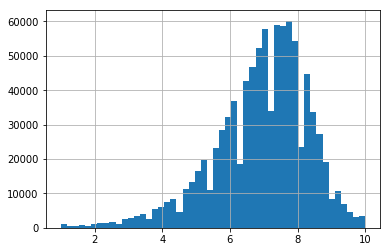

In [8]:
%matplotlib inline
title_ratings_df.averageRating.hist(bins = 50)

## Filtering the cast dataframe
From the Ratings dataframe we choose to focus on movies that had more than 1500 reviews and those that were released after 1990. 

This is done to avoid obscure or unpopular movies and also to avoid possible bias with a small number of reviews. A large number of review should reduce noise in capturing the 'goodness' of a movie. 

In [394]:


ratings_filt = title_ratings_df[title_ratings_df.numVotes > 1500]



merged_df = title_basics_df.merge(ratings_filt, on='tconst', how='inner')

merged_title_df = merged_df[(merged_df.startYear > 1990) & (merged_df.titleType == 'movie')]



## Categorical embeddings for important cast members

- For the task of predicting average movie ratings on IMDB, we will filter on average number of votes as well as release date. We will focus our attention on 'modern' movies i.e. those that were released after 1990 and those movies with atleast 1500 reviews. This is done to avoid obscure or unpopular movies and also to avoid possible bias with a small number of reviews. A large number of review should reduce noise in capturing the 'goodness' of a movie. 

- The hypothesis is that for each movie the key contributing factors to its success are the **cast, the director, producer etc**. There are about ~7000 unique individuals involved with the movies for the period we have filtered. Therefore, we convert these high cardinality categorical variables of key cast members into fixed dimensional embeddings of length 16. For each movie we will sum up the vectors to represent their combined effect for a movie. We will also try a model where the embeddings for each of the cast members is concatenated for comparison.


#### An intuitive explanation for the categorical embeddings:
*A high cardinality categorical variable with say 7000 unique values can be thought of as a grouping of say 16 main categories. A tangible example would be: Actors can be classified as Action, Romance, Comedy etc. specialists. Loosely speaking, each of the 16 dimensions in the embedding could represent how much of Action or Comedy or Romance an actor is 'good' at. Thus each dimension acts as a lever. Ofcourse, this is a synthetic example and the 16 dimensions may not represent anything that we are familiar with. However, the model may learn embeddings that represent a notion of closeness to other features like movie genre or other people working on a movie. A real life example could be, given that a movie is made by Tim Burton, there is a very high likelihood of Johnny Depp starring in it.*



Likewise, the Genre categorical variable will also be converted into an embedding of length 10.



In [560]:
# Isolate the cast information dataframe to get movies that we are interested in
cast_filt = title_cast_df[title_cast_df.tconst.isin(merged_title_df.tconst.unique())]

cast_filt.sort_values(by=['tconst', 'ordering'], inplace=True)

/Users/adityajadhav/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [400]:
cast_filt.head()

,tconst,ordering,nconst,category,job,characters
280730,tt0035423,1,nm0000212,actress,\N,"[""Kate McKay""]"
280731,tt0035423,2,nm0413168,actor,\N,"[""Leopold""]"
280732,tt0035423,3,nm0000630,actor,\N,"[""Stuart Besser""]"
280733,tt0035423,4,nm0005227,actor,\N,"[""Charlie McKay""]"
280734,tt0035423,5,nm0003506,director,\N,\N


In [561]:
# Converting the string id of each person in the cast to a numeric label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(cast_filt.nconst)
cast_filt.nconst = le.transform(cast_filt.nconst)

/Users/adityajadhav/anaconda3/envs/myenv/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [563]:

# Converting the long format cast dataframe into a wide format
# Here we have 10 of the most important cast members for each movie
cast_filt_wide = cast_filt.pivot(index='tconst', columns='ordering', values='nconst')

cast_filt_wide.reset_index(inplace=True)


# Fill up missing values with the token 70019. 0-70018 are the tokens for all the
# unique individual cast members. 
cast_filt_wide.fillna(value=70019, inplace=True)


## Merging the cast information with the movie rating dataframe
merged_title_df = merged_title_df.merge(cast_filt_wide, on='tconst')



merged_title_df['genres'] = merged_title_df['genres'].apply(clean_genre)


# Creating X and y variables for ML pipeline
X = merged_title_df[['startYear', 'runtimeMinutes',         'genres',
               'numVotes',                1,                2,
                      3,                4,                5,                6,
                      7,                8,                9,               10]]
y = merged_title_df[['averageRating']]

In [564]:
#y.averageRating = round(y.averageRating)

In [565]:
## Converting string genres into integer tokens
le.fit(X.genres)
X.genres = le.transform(X.genres)

In [566]:
from sklearn.model_selection import train_test_split

In [567]:
# Splitting data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.2, random_state = 42)

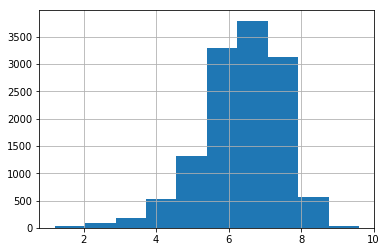

In [502]:
# Visualizing the distribution of ratings in training set
y_train.averageRating.hist()

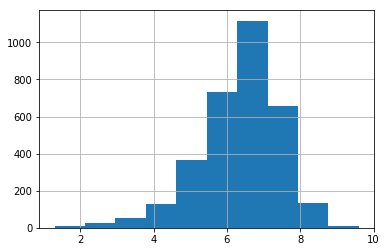

In [503]:
# Visualizing the distribution of ratings in test set
y_test.averageRating.hist()

 ### Approach 1.1 : Categorical Embedding Neural network (Addition)

In [509]:

from numpy import unique


# Count the unique number of teams
n_ppl = len(cast_filt.nconst.unique()) + 1

# Create an embedding layer
ppl_lookup = Embedding(input_dim=n_ppl,
                        output_dim=16,
                        input_length=1,
                        name='Ppl-Vectors')
                        
# The unique person id is input
pid_in = Input(shape=(1,))

# Lookup the input in the person id embedding layer
pplid_lookup = ppl_lookup(pid_in)

# Flatten the output
pplid_lookup_flat = Flatten()(pplid_lookup)

# Combine the operations into a single, re-usable model for cast member embeddings
ppl_embed_model = Model(pid_in, pplid_lookup_flat, name='Ppl-Vector-Model')



# Count the unique number of genres
n_genres = unique(X['genres']).shape[0]

# Create an embedding layer for genres
genre_lookup = Embedding(input_dim=n_genres,
                        output_dim=10,
                        input_length=1,
                        name='Genre-Vectors')
                        
# Input genre token
genre_in = Input(shape=(1,))

# Lookup the input in the genre embedding layer
genreid_lookup = genre_lookup(genre_in)

# Flatten the output
genreid_lookup_flat = Flatten()(genreid_lookup)

# Combine the operations into a single, re-usable model for genre embeddings
genre_embed_model = Model(genre_in, genreid_lookup_flat, name='Genre-Vector-Model')




# Create an Input for each cast member. There are upto 10 given for each movie
p_in_1 = Input(shape=(1,), name='P-1-In')
p_in_2 = Input(shape=(1,), name='P-2-In')
p_in_3 = Input(shape=(1,), name='P-3-In')
p_in_4 = Input(shape=(1,), name='P-4-In')
p_in_5 = Input(shape=(1,), name='P-5-In')
p_in_6 = Input(shape=(1,), name='P-6-In')
p_in_7 = Input(shape=(1,), name='P-7-In')
p_in_8 = Input(shape=(1,), name='P-8-In')
p_in_9 = Input(shape=(1,), name='P-9-In')
p_in_10 = Input(shape=(1,), name='P-10-In')

# Create an Input for each genre, 
genre_in = Input(shape=(1,), name='Genre-In')


# Create a numerical input for runtime in minutes and number of votes
runtime_in = Input(shape=(1,), name='Runtime-In')
votes_in = Input(shape=(1,), name='Votes-In')

# Lookup the cast member inputs in the cast member embedding model
p_1_strength = ppl_embed_model(p_in_1)
p_2_strength = ppl_embed_model(p_in_2)
p_3_strength = ppl_embed_model(p_in_3)
p_4_strength = ppl_embed_model(p_in_4)
p_5_strength = ppl_embed_model(p_in_5)
p_6_strength = ppl_embed_model(p_in_6)
p_7_strength = ppl_embed_model(p_in_7)
p_8_strength = ppl_embed_model(p_in_8)
p_9_strength = ppl_embed_model(p_in_9)
p_10_strength = ppl_embed_model(p_in_10)

genre_strength = genre_embed_model(genre_in)


# Combine the cast member embeddings using an Add layer, 
# then using Concatenate to concatenate the genre, runtime and num_votes inputs
# Finally adding a add a single output Dense layer

out1 = Add()([p_1_strength,p_2_strength,p_3_strength,p_4_strength,p_5_strength,
             p_6_strength,p_7_strength,p_8_strength,p_9_strength,p_10_strength])
out = Concatenate()([out1, genre_strength, runtime_in, votes_in])
#out = Dense(64, activation='relu')(out)
#out2 = Dense(4, activation='relu')(out)
#out4 = Dense(16, activation='relu')(out2)
out3 = Dense(1)(out)


# Import the model class
from tensorflow.keras.models import Model

# Make a Model
ip = [p_in_1,p_in_2,p_in_3,p_in_4,p_in_5,p_in_6,p_in_7,p_in_8,p_in_9,p_in_10,genre_in, runtime_in, votes_in]
model = Model(ip, out3)

# Compile the model. Use MAE as performance metric
model.compile(optimizer='adam', loss='mean_absolute_error')


# Fit the model to the training dataset
ip2 = [X_train[1], X_train[2],X_train[3],X_train[4],
     X_train[5],X_train[6],X_train[7], X_train[8],
     X_train[9], X_train[10], X_train.genres, X_train.runtimeMinutes,
       X_train.numVotes]
model.fit(ip2,
          y_train.averageRating,
          epochs=50,
          verbose=True,
          validation_split=.10,
          batch_size=256)



Train on 11670 samples, validate on 1297 samples
Epoch 1/50
11670/11670 [==============================] - 1s 106us/sample - loss: 3793.7826 - val_loss: 3504.0401
Epoch 2/50
11670/11670 [==============================] - 1s 60us/sample - loss: 2143.1016 - val_loss: 1537.6804
Epoch 3/50
11670/11670 [==============================] - 1s 59us/sample - loss: 540.5520 - val_loss: 90.2394
Epoch 4/50
11670/11670 [==============================] - 1s 56us/sample - loss: 14.7458 - val_loss: 8.1300
Epoch 5/50
11670/11670 [==============================] - 1s 58us/sample - loss: 3.8157 - val_loss: 2.7080
Epoch 6/50
11670/11670 [==============================] - 1s 52us/sample - loss: 7.0704 - val_loss: 8.7655
Epoch 7/50
11670/11670 [==============================] - 1s 59us/sample - loss: 4.9315 - val_loss: 13.0760
Epoch 8/50
11670/11670 [==============================] - 1s 58us/sample - loss: 5.4170 - val_loss: 3.6418
Epoch 9/50
11670/11670 [==============================] - 1s 57us/sample - lo

In [510]:
ip_test = [X_test[1], X_test[2],X_test[3],X_test[4],
     X_test[5],X_test[6],X_test[7], X_test[8],
     X_test[9], X_test[10], X_test.genres, X_test.runtimeMinutes,
       X_test.numVotes]

y_pred = model.predict(ip_test)

In [511]:
model.evaluate(ip_test, y_test)

3242/3242 [==============================] - 0s 49us/sample - loss: 1.5635


1.56347756309321

### Apporach 1.1 Test MAE : 1.563

In [512]:
y_pred

array([[4.839862 ],
       [5.7994475],
       [6.030299 ],
       ...,
       [4.8653235],
       [5.6613107],
       [5.7518144]], dtype=float32)

In [513]:
y_test.head()

,averageRating
4226,6.2
11070,8.3
2450,6.9
1493,5.4
3894,5.0


(array([1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 2.000e+00,
        7.000e+00, 1.700e+01, 2.800e+01, 2.270e+02, 7.490e+02, 1.109e+03,
        7.870e+02, 2.630e+02, 3.300e+01, 7.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([-6.13375   , -5.162877  , -4.1920047 , -3.2211318 , -2.250259  ,
        -1.2793863 , -0.30851355,  0.6623592 ,  1.6332319 ,  2.6041048 ,
         3.5749774 ,  4.5458503 ,  5.5167227 ,  6.4875956 ,  7.4584684 ,
         8.429341  ,  9.400214  , 10.371086  , 11.341959  , 12.312832  ,
        13.283705  ], dtype=float32),
 <a list of 20 Patch objects>)

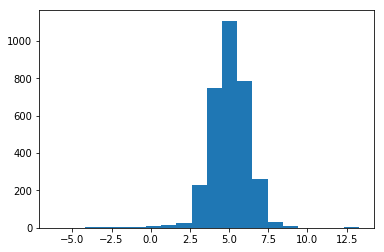

In [520]:
# Visualizing predicted ratings distribution
from matplotlib import pyplot as plt
plt.hist(y_pred, bins=20)

## Approach 1.2 Categorical Embedding Neural Network with Concatenated combination

In [568]:
## Same as above except all the cast member embeddings are combined via concatenation
# instead of addition

from numpy import unique


# Count the unique number of teams
n_ppl = len(cast_filt.nconst.unique()) + 1

# Create an embedding layer
ppl_lookup = Embedding(input_dim=n_ppl,
                        output_dim=16,
                        input_length=1,
                        name='Ppl-Vectors')
                        

pid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
pplid_lookup = ppl_lookup(pid_in)

# Flatten the output
pplid_lookup_flat = Flatten()(pplid_lookup)

# Combine the operations into a single, re-usable model
ppl_embed_model = Model(pid_in, pplid_lookup_flat, name='Ppl-Vector-Model')



# Count the unique number of teams
n_genres = unique(X['genres']).shape[0]

# Create an embedding layer
genre_lookup = Embedding(input_dim=n_genres,
                        output_dim=10,
                        input_length=1,
                        name='Genre-Vectors')
                        

genre_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
genreid_lookup = genre_lookup(genre_in)

# Flatten the output
genreid_lookup_flat = Flatten()(genreid_lookup)

# Combine the operations into a single, re-usable model
genre_embed_model = Model(genre_in, genreid_lookup_flat, name='Genre-Vector-Model')




# Create an Input for each team
p_in_1 = Input(shape=(1,), name='P-1-In')
p_in_2 = Input(shape=(1,), name='P-2-In')
p_in_3 = Input(shape=(1,), name='P-3-In')
p_in_4 = Input(shape=(1,), name='P-4-In')
p_in_5 = Input(shape=(1,), name='P-5-In')
p_in_6 = Input(shape=(1,), name='P-6-In')
p_in_7 = Input(shape=(1,), name='P-7-In')
p_in_8 = Input(shape=(1,), name='P-8-In')
p_in_9 = Input(shape=(1,), name='P-9-In')
p_in_10 = Input(shape=(1,), name='P-10-In')

genre_in = Input(shape=(1,), name='Genre-In')


# Create an input for home vs away
runtime_in = Input(shape=(1,), name='Runtime-In')
votes_in = Input(shape=(1,), name='Votes-In')

# Lookup the team inputs in the team strength model
p_1_strength = ppl_embed_model(p_in_1)
p_2_strength = ppl_embed_model(p_in_2)
p_3_strength = ppl_embed_model(p_in_3)
p_4_strength = ppl_embed_model(p_in_4)
p_5_strength = ppl_embed_model(p_in_5)
p_6_strength = ppl_embed_model(p_in_6)
p_7_strength = ppl_embed_model(p_in_7)
p_8_strength = ppl_embed_model(p_in_8)
p_9_strength = ppl_embed_model(p_in_9)
p_10_strength = ppl_embed_model(p_in_10)

genre_strength = genre_embed_model(genre_in)


# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out1 = Concatenate()([p_1_strength,p_2_strength,p_3_strength,p_4_strength,p_5_strength,
             p_6_strength,p_7_strength,p_8_strength,p_9_strength,p_10_strength])
out = Concatenate()([out1, genre_strength, runtime_in, votes_in])
#out = Dense(64, activation='relu')(out)
#out2 = Dense(4, activation='relu')(out)
#out4 = Dense(16, activation='relu')(out2)
out3 = Dense(1)(out)


# Import the model class
from tensorflow.keras.models import Model

# Make a Model
ip = [p_in_1,p_in_2,p_in_3,p_in_4,p_in_5,p_in_6,p_in_7,p_in_8,p_in_9,p_in_10,genre_in, runtime_in, votes_in]
model = Model(ip, out3)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')


# Fit the model to the games_season dataset
ip2 = [X_train[1], X_train[2],X_train[3],X_train[4],
     X_train[5],X_train[6],X_train[7], X_train[8],
     X_train[9], X_train[10], X_train.genres, X_train.runtimeMinutes,
       X_train.numVotes]
model.fit(ip2,
          y_train.averageRating,
          epochs=50,
          verbose=True,
          validation_split=.10,
          batch_size=256)



Train on 11670 samples, validate on 1297 samples
Epoch 1/50
11670/11670 [==============================] - 1s 103us/sample - loss: 1344.2776 - val_loss: 586.1882
Epoch 2/50
11670/11670 [==============================] - 1s 45us/sample - loss: 120.2380 - val_loss: 19.6988
Epoch 3/50
11670/11670 [==============================] - 1s 56us/sample - loss: 17.9379 - val_loss: 14.6231
Epoch 4/50
11670/11670 [==============================] - 1s 53us/sample - loss: 12.8006 - val_loss: 10.3547
Epoch 5/50
11670/11670 [==============================] - 1s 47us/sample - loss: 9.0662 - val_loss: 15.2258
Epoch 6/50
11670/11670 [==============================] - 1s 64us/sample - loss: 6.6978 - val_loss: 5.6765
Epoch 7/50
11670/11670 [==============================] - 1s 59us/sample - loss: 5.6627 - val_loss: 3.0697
Epoch 8/50
11670/11670 [==============================] - 1s 60us/sample - loss: 5.5527 - val_loss: 1.8088
Epoch 9/50
11670/11670 [==============================] - 1s 55us/sample - loss: 

In [569]:
ip_test = [X_test[1], X_test[2],X_test[3],X_test[4],
     X_test[5],X_test[6],X_test[7], X_test[8],
     X_test[9], X_test[10], X_test.genres, X_test.runtimeMinutes,
       X_test.numVotes]

y_pred = model.predict(ip_test)

In [575]:
mean_absolute_error(y_test.averageRating, y_pred)

8.512035473859434

### Approach 1.2 MAE : 8.5

## Approach 2: RandomForestRegressor

In [577]:
cast_filt2 = title_cast_df[title_cast_df.tconst.isin(merged_title_df.tconst.unique())]

cast_filt2.sort_values(by=['tconst', 'ordering'], inplace=True)

/Users/adityajadhav/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [578]:
cast_filt_wide2 = cast_filt2.pivot(index='tconst', columns='ordering', values='nconst')

cast_filt_wide2.reset_index(inplace=True)

#cast_filt_wide.fillna(value=70019, inplace=True)
merged_title_df2 = merged_df[(merged_df.startYear > 1990) & (merged_df.titleType == 'movie')]

merged_title_df2 = merged_title_df2.merge(cast_filt_wide2, on='tconst')

merged_title_df2['genres'] = merged_title_df2['genres'].apply(clean_genre)

X2 = merged_title_df2[['startYear', 'runtimeMinutes',         'genres',
               'numVotes',                1,                2,
                      3,                4,                5,                6,
                      7,                8,                9,               10]]
y2 = merged_title_df2[['averageRating']]

In [579]:
X2 = X2.drop(columns=[2,3,4,5,6,7,8,9,10])

In [580]:
X2 = pd.get_dummies(X2)

In [581]:
from sklearn.ensemble import RandomForestRegressor

In [582]:
rf = RandomForestRegressor()

In [583]:
X2 = X2.drop(columns=['startYear'])

In [584]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state = 34)

In [585]:
rf.fit(X_train, y_train)

/Users/adityajadhav/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/adityajadhav/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [548]:
rf.score(X_test, y_test)

0.2621867248784563

In [549]:
rf.predict(X_test)

array([7.32, 6.55, 5.81, ..., 6.75, 6.41, 7.61])

In [553]:
rf_params = {
 'max_depth': [10, 40, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]
 }

In [551]:
from sklearn.model_selection import RandomizedSearchCV

In [595]:
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions=rf_params , 
                               n_iter = 20, cv = 5, verbose=2, 
                               random_state=42,
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.1min finished
/Users/adityajadhav/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'max_depth': [10, 40, 80, 100, None], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [596]:
rf_random.score(X_test, y_test)

0.30076294829154504

In [597]:
rf_pred = rf_random.predict(X_test)

In [598]:
mean_absolute_error(rf_pred, y_test.averageRating)

0.6872563533185294

### Approach 2 has a test MAE of 0.6872

## Conclusion : The Random Forest regressor providesthe best performance than the embedding space neural network.

## Next Steps
- If I had more time, I would fine tune the Categorical Embedding model further. Maybe tuned the number of cast members that we care about. 
- Also, I would tune the embeddings sizes
- I would also experiment with using the transformed dataset after obtaining the embeddings and fed it into the Random Forest regressor.